In [3]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
)

In [4]:
# 1) Load artifacts

preprocessor = joblib.load("preprocessor.pkl")
X_train, X_test, y_train, y_test = joblib.load("splits.pkl")

# Transform and apply SMOTE
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_proc, y_train)

results = []   # store all models' scores
models = {}    # keep trained models

In [5]:
# Helper function

def train_and_evaluate(name, model):
    """Fit, evaluate, and collect results for each model"""
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1] if hasattr(model, "predict_proba") else None

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc_ = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # cross-validation (5-fold, to strengthen evaluation)
    cv_acc = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="accuracy").mean()

    results.append({
        "Model": name,
        "Accuracy": acc,
        "CV Accuracy": cv_acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC AUC": auc_
    })

    models[name] = model

     # ---- Print detailed results
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ---- Confusion Matrix Heatmap
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ---- ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_:.2f})")
        plt.plot([0,1],[0,1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.show()


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.90      0.46      0.61     17762
           1       0.10      0.54      0.17      1976

    accuracy                           0.47     19738
   macro avg       0.50      0.50      0.39     19738
weighted avg       0.82      0.47      0.57     19738

Confusion Matrix:
 [[8258 9504]
 [ 910 1066]]


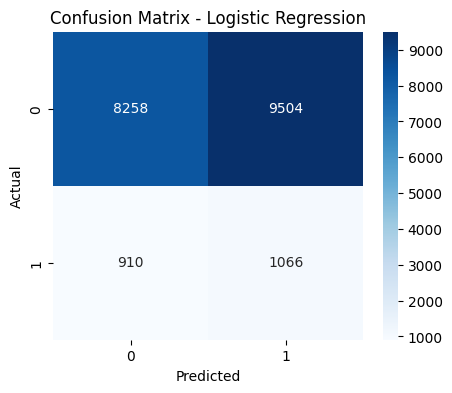

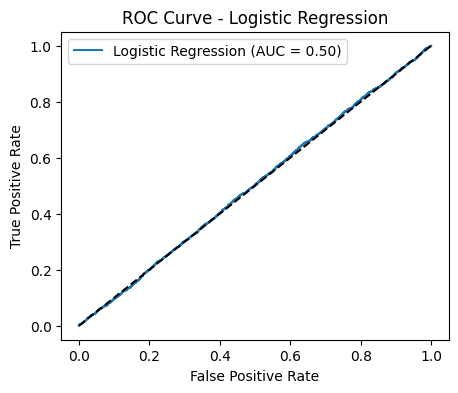

In [6]:
# 2) Logistic Regression

log_reg = LogisticRegression(
    max_iter=2000, solver="lbfgs", class_weight="balanced", random_state=42
)
train_and_evaluate("Logistic Regression", log_reg)

In [ ]:
# 3) Random Forest

rf = RandomForestClassifier(
    n_estimators=400, max_depth=15, min_samples_split=5,
    class_weight="balanced_subsample", random_state=42
)
train_and_evaluate("Random Forest", rf)


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17762
           1       0.00      0.00      0.00      1976

    accuracy                           0.90     19738
   macro avg       0.45      0.50      0.47     19738
weighted avg       0.81      0.90      0.85     19738

Confusion Matrix:
 [[17762     0]
 [ 1976     0]]


c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

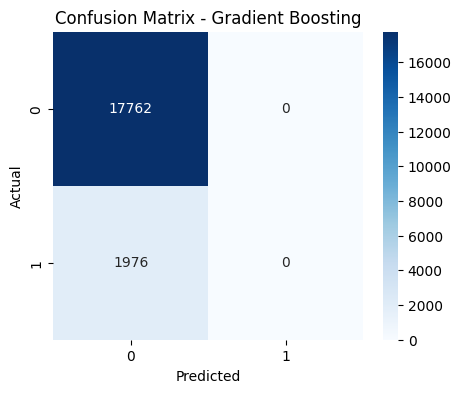

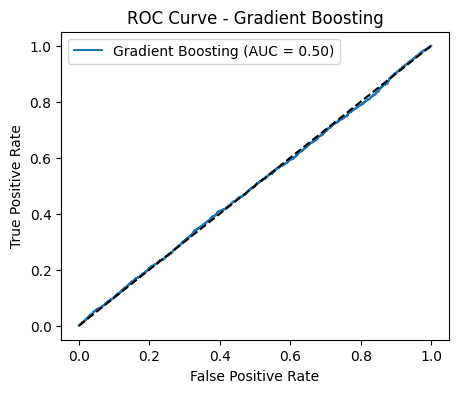

In [7]:
# 4) Gradient Boosting

gb = GradientBoostingClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42
)
train_and_evaluate("Gradient Boosting", gb)



=== XGBoost ===
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     17762
           1       0.00      0.00      0.00      1976

    accuracy                           0.90     19738
   macro avg       0.45      0.50      0.47     19738
weighted avg       0.81      0.90      0.85     19738

Confusion Matrix:
 [[17762     0]
 [ 1976     0]]


c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\navoo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

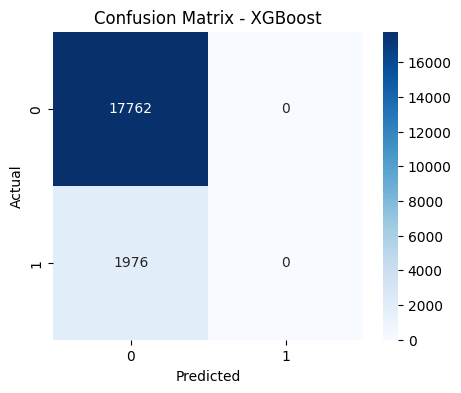

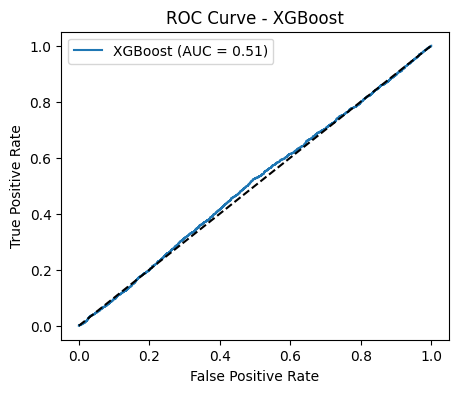

In [8]:
# 5) XGBoost

xgb = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", random_state=42
)
train_and_evaluate("XGBoost", xgb)

In [ ]:
# 6) Compare Models

results_df = pd.DataFrame(results).set_index("Model")
print("\n=== Model Comparison ===\n", results_df)

plt.figure(figsize=(12,6))
sns.barplot(
    data=results_df.reset_index().melt(id_vars="Model", var_name="Metric", value_name="Score"),
    x="Model", y="Score", hue="Metric"
)
plt.title("Model Comparison")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


NameError: name 'pd' is not defined

In [2]:
# 7) Feature Importance (Tree Models Only)

for name, model in [("Random Forest", rf), ("Gradient Boosting", gb), ("XGBoost", xgb)]:
    importances = model.feature_importances_
    feat_names = preprocessor.get_feature_names_out()
    feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)[:10]

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title(f"Top 10 Features - {name}")
    plt.show()

NameError: name 'rf' is not defined

In [16]:
# 8) Choose Best Model (prioritize F1, then ROC AUC)

best_row = results_df.sort_values(by=["F1","ROC AUC","Accuracy"], ascending=False).iloc[0]
best_model_name = best_row.name
print(f"\n✅ Best Model: {best_model_name}")
print(best_row)

joblib.dump(models[best_model_name], "employee_best_model.pkl")
print("✅ Saved best trained model as employee_best_model.pkl")


✅ Best Model: Logistic Regression
Accuracy       0.472388
CV Accuracy    0.518670
Precision      0.100851
Recall         0.539474
F1             0.169935
ROC AUC        0.502281
Name: Logistic Regression, dtype: float64
✅ Saved best trained model as employee_best_model.pkl
